# Data Cleaning and Transformation

In this notebook we analyze the demographics data for the general population of Germany dataset **Udacity_AZDIAS_052018.csv**

## Import libraries

In [1]:
import numpy as np
import pandas as pd

from joblib import dump, load

import missingno as msno

from time import time
from collections import OrderedDict, Counter

from tqdm.auto import tqdm, trange
tqdm.pandas()

from utils.transformers import *
from utils.functions import *

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline 
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# magic word for producing visualizations in notebook
%matplotlib inline

## Load the Data

### General Population

In [2]:
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


The feature names are not very explanatory but fortunately for us along with the datasets, two other files were provided:

* *DIAS Information Levels - Attributes 2017.xlsx*: Describes each feature.
* *DIAS Attributes - Values 2017.xlsx*: Describes the type of each feature along with possible values along with values that represent missing or unknow information.

### Feature Info

As we can see the dataset contains a lot of missing values (represented by NAN in table above) and some of the values, like (-1, 0 or 9) also indicate missing or unknown information. In order to replace the missing values automatically we've built a csv file to hold this information

In [3]:
feat_info = pd.read_csv('data/AZDIAS_Feature_Summary.csv', sep=';')
feat_info

,attribute,type,missing_or_unknown,information_level
0,AGER_TYP,categorical,"[-1,0]",person
1,ALTERSKATEGORIE_GROB,ordinal,"[-1,0,9]",person
2,ALTER_HH,interval,[0],household
3,ANREDE_KZ,categorical,"[-1,0]",person
4,ANZ_HAUSHALTE_AKTIV,numeric,[],building
5,ANZ_HH_TITEL,numeric,[],building
6,ANZ_PERSONEN,numeric,[],household
7,ANZ_TITEL,numeric,[],household
8,BALLRAUM,ordinal,[-1],postcode
9,CAMEO_DEUG_2015,categorical,"[-1,X]",microcell_rr4


## Analysis

### Missing Values

#### Assess Missing Data

The following figure, obtained using the `missingno` package shows the missing values of the provided data:

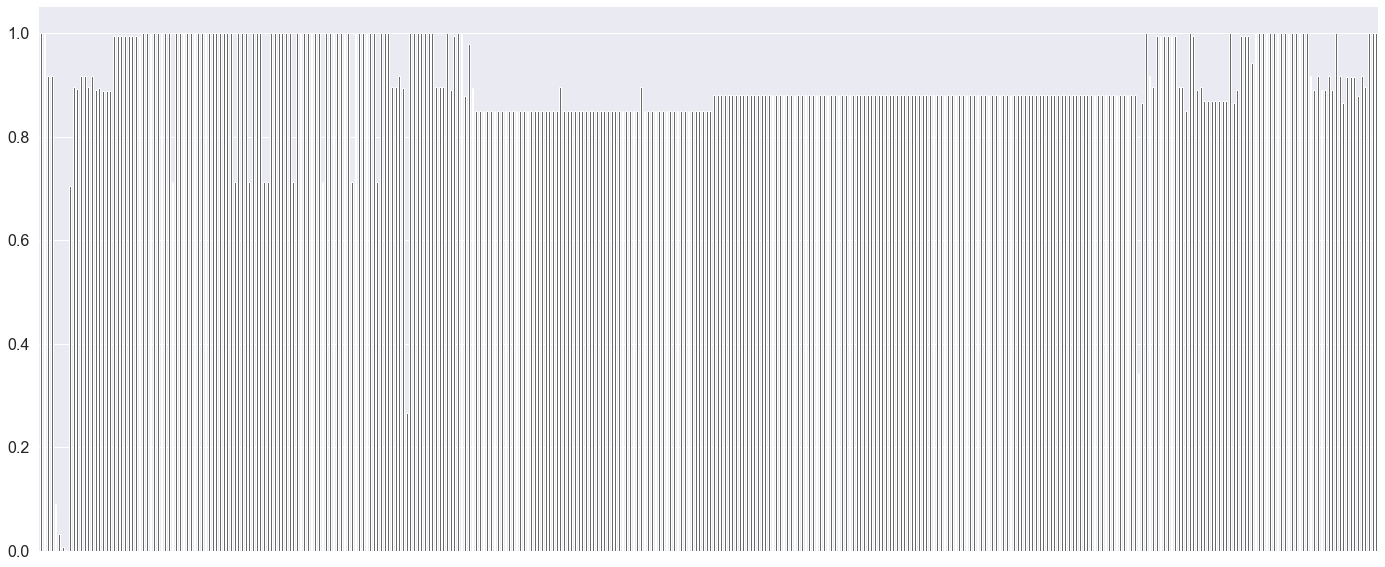

In [4]:
ax = msno.bar(azdias)

Let's apply `feat_info` defined above by using a utility function called `replace_missing_or_unknown`

In [5]:
# The following columns will be droped because they are metadata columns
drop_features = ['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']

azdias = azdias.drop(drop_features, axis=1)
azdias = replace_missing_or_unknown(azdias, feat_info)
azdias.head()

Processing AGER_TYP



Processing ALTERSKATEGORIE_GROB



Processing ALTER_HH



Processing ANREDE_KZ



Processing BALLRAUM



Processing CAMEO_DEUG_2015



Processing CAMEO_DEU_2015



Processing CAMEO_INTL_2015



Processing CJT_GESAMTTYP



Processing D19_BANKEN_ANZ_12



Processing D19_BANKEN_ANZ_24



Processing D19_BANKEN_DATUM



Processing D19_BANKEN_DIREKT



Processing D19_BANKEN_GROSS



Processing D19_BANKEN_LOKAL



Processing D19_BANKEN_OFFLINE_DATUM



Processing D19_BANKEN_ONLINE_DATUM



Processing D19_BANKEN_REST



Processing D19_BEKLEIDUNG_GEH



Processing D19_BEKLEIDUNG_REST



Processing D19_BILDUNG



Processing D19_BIO_OEKO



Processing D19_BUCH_CD



Processing D19_DIGIT_SERV



Processing D19_DROGERIEARTIKEL



Processing D19_ENERGIE



Processing D19_FREIZEIT



Processing D19_GARTEN



Processing D19_GESAMT_ANZ_12



Processing D19_GESAMT_ANZ_24



Processing D19_GESAMT_DATUM



Processing D19_GESAMT_OFFLINE_DATUM



Processing D19_GESAMT_ONLINE_DATUM



Processing D19_HANDWERK



Processing D19_HAUS_DEKO



Processing D19_KINDERARTIKEL



Processing KK_KUNDENTYP



Processing D19_KOSMETIK



Processing D19_LEBENSMITTEL



Processing D19_LOTTO



Processing D19_NAHRUNGSERGAENZUNG



Processing D19_RATGEBER



Processing D19_REISEN



Processing D19_SAMMELARTIKEL



Processing D19_SCHUHE



Processing D19_SONSTIGE



Processing D19_TECHNIK



Processing D19_TELKO_ANZ_12



Processing D19_TELKO_ANZ_24



Processing D19_TELKO_DATUM



Processing D19_TELKO_MOBILE



Processing D19_TELKO_OFFLINE_DATUM



Processing D19_TELKO_ONLINE_DATUM



Processing D19_TELKO_REST



Processing D19_TIERARTIKEL



Processing D19_VERSAND_ANZ_12



Processing D19_VERSAND_ANZ_24



Processing D19_VERSAND_DATUM



Processing D19_VERSAND_OFFLINE_DATUM



Processing D19_VERSAND_ONLINE_DATUM



Processing D19_VERSAND_REST



Processing D19_VERSICHERUNGEN



Processing D19_VERSI_ANZ_12



Processing D19_VERSI_ANZ_24



Processing D19_VOLLSORTIMENT



Processing D19_WEIN_FEINKOST



Processing EWDICHTE



Processing FINANZTYP



Processing FINANZ_ANLEGER



Processing FINANZ_HAUSBAUER



Processing FINANZ_MINIMALIST



Processing FINANZ_SPARER



Processing FINANZ_UNAUFFAELLIGER



Processing FINANZ_VORSORGER



Processing GEBAEUDETYP



Processing GEBURTSJAHR



Processing HEALTH_TYP



Processing HH_EINKOMMEN_SCORE



Processing INNENSTADT



Processing KBA05_ALTER1



Processing KBA05_ALTER2



Processing KBA05_ALTER3



Processing KBA05_ALTER4



Processing KBA05_ANHANG



Processing KBA05_ANTG1



Processing KBA05_ANTG2



Processing KBA05_ANTG3



Processing KBA05_ANTG4



Processing KBA05_AUTOQUOT



Processing KBA05_BAUMAX



Processing KBA05_CCM1



Processing KBA05_CCM2



Processing KBA05_CCM3



Processing KBA05_CCM4



Processing KBA05_DIESEL



Processing KBA05_FRAU



Processing KBA05_GBZ



Processing KBA05_HERST1



Processing KBA05_HERST2



Processing KBA05_HERST3



Processing KBA05_HERST4



Processing KBA05_HERST5



Processing KBA05_HERSTTEMP



Processing KBA05_KRSAQUOT



Processing KBA05_KRSHERST1



Processing KBA05_KRSHERST2



Processing KBA05_KRSHERST3



Processing KBA05_KRSKLEIN



Processing KBA05_KRSOBER



Processing KBA05_KRSVAN



Processing KBA05_KRSZUL



Processing KBA05_KW1



Processing KBA05_KW2



Processing KBA05_KW3



Processing KBA05_MAXAH



Processing KBA05_MAXBJ



Processing KBA05_MAXHERST



Processing KBA05_MAXSEG



Processing KBA05_MAXVORB



Processing KBA05_MOD1



Processing KBA05_MOD2



Processing KBA05_MOD3



Processing KBA05_MOD4



Processing KBA05_MOD8



Processing KBA05_MODTEMP



Processing KBA05_MOTOR



Processing KBA05_MOTRAD



Processing KBA05_SEG1



Processing KBA05_SEG10



Processing KBA05_SEG2



Processing KBA05_SEG3



Processing KBA05_SEG4



Processing KBA05_SEG5



Processing KBA05_SEG6



Processing KBA05_SEG7



Processing KBA05_SEG8



Processing KBA05_SEG9



Processing KBA05_VORB0



Processing KBA05_VORB1



Processing KBA05_VORB2



Processing KBA05_ZUL1



Processing KBA05_ZUL2



Processing KBA05_ZUL3



Processing KBA05_ZUL4



Processing KBA13_ALTERHALTER_30



Processing KBA13_ALTERHALTER_45



Processing KBA13_ALTERHALTER_60



Processing KBA13_ALTERHALTER_61



Processing KBA13_AUDI



Processing KBA13_AUTOQUOTE



Processing KBA13_BJ_1999



Processing KBA13_BJ_2000



Processing KBA13_BJ_2004



Processing KBA13_BJ_2006



Processing KBA13_BJ_2008



Processing KBA13_BJ_2009



Processing KBA13_BMW



Processing KBA13_CCM_1000



Processing KBA13_CCM_1200



Processing KBA13_CCM_1400



Processing KBA13_CCM_0_1400



Processing KBA13_CCM_1500



Processing KBA13_CCM_1600



Processing KBA13_CCM_1800



Processing KBA13_CCM_2000



Processing KBA13_CCM_2500



Processing KBA13_CCM_2501



Processing KBA13_CCM_3000



Processing KBA13_CCM_3001



Processing KBA13_FAB_ASIEN



Processing KBA13_FAB_SONSTIGE



Processing KBA13_FIAT



Processing KBA13_FORD



Processing KBA13_HALTER_20



Processing KBA13_HALTER_25



Processing KBA13_HALTER_30



Processing KBA13_HALTER_35



Processing KBA13_HALTER_40



Processing KBA13_HALTER_45



Processing KBA13_HALTER_50



Processing KBA13_HALTER_55



Processing KBA13_HALTER_60



Processing KBA13_HALTER_65



Processing KBA13_HALTER_66



Processing KBA13_HERST_ASIEN



Processing KBA13_HERST_AUDI_VW



Processing KBA13_HERST_BMW_BENZ



Processing KBA13_HERST_EUROPA



Processing KBA13_HERST_FORD_OPEL



Processing KBA13_HERST_SONST



Processing KBA13_KMH_110



Processing KBA13_KMH_140



Processing KBA13_KMH_180



Processing KBA13_KMH_0_140



Processing KBA13_KMH_140_210



Processing KBA13_KMH_211



Processing KBA13_KMH_250



Processing KBA13_KMH_251



Processing KBA13_KRSAQUOT



Processing KBA13_KRSHERST_AUDI_VW



Processing KBA13_KRSHERST_BMW_BENZ



Processing KBA13_KRSHERST_FORD_OPEL



Processing KBA13_KRSSEG_KLEIN



Processing KBA13_KRSSEG_OBER



Processing KBA13_KRSSEG_VAN



Processing KBA13_KRSZUL_NEU



Processing KBA13_KW_30



Processing KBA13_KW_40



Processing KBA13_KW_50



Processing KBA13_KW_60



Processing KBA13_KW_0_60



Processing KBA13_KW_70



Processing KBA13_KW_61_120



Processing KBA13_KW_80



Processing KBA13_KW_90



Processing KBA13_KW_110



Processing KBA13_KW_120



Processing KBA13_KW_121



Processing KBA13_MAZDA



Processing KBA13_MERCEDES



Processing KBA13_MOTOR



Processing KBA13_NISSAN



Processing KBA13_OPEL



Processing KBA13_PEUGEOT



Processing KBA13_RENAULT



Processing KBA13_SEG_GELAENDEWAGEN



Processing KBA13_SEG_GROSSRAUMVANS



Processing KBA13_SEG_KLEINST



Processing KBA13_SEG_KLEINWAGEN



Processing KBA13_SEG_KOMPAKTKLASSE



Processing KBA13_SEG_MINIVANS



Processing KBA13_SEG_MINIWAGEN



Processing KBA13_SEG_MITTELKLASSE



Processing KBA13_SEG_OBEREMITTELKLASSE



Processing KBA13_SEG_OBERKLASSE



Processing KBA13_SEG_SONSTIGE



Processing KBA13_SEG_SPORTWAGEN



Processing KBA13_SEG_UTILITIES



Processing KBA13_SEG_VAN



Processing KBA13_SEG_WOHNMOBILE



Processing KBA13_SITZE_4



Processing KBA13_SITZE_5



Processing KBA13_SITZE_6



Processing KBA13_TOYOTA



Processing KBA13_VORB_0



Processing KBA13_VORB_1



Processing KBA13_VORB_1_2



Processing KBA13_VORB_2



Processing KBA13_VORB_3



Processing KBA13_VW



Processing KKK



Processing LP_FAMILIE_FEIN



Processing LP_FAMILIE_GROB



Processing LP_LEBENSPHASE_FEIN



Processing LP_LEBENSPHASE_GROB



Processing LP_STATUS_FEIN



Processing LP_STATUS_GROB



Processing NATIONALITAET_KZ



Processing ORTSGR_KLS9



Processing OST_WEST_KZ



Processing PLZ8_ANTG1



Processing PLZ8_ANTG2



Processing PLZ8_ANTG3



Processing PLZ8_ANTG4



Processing PLZ8_GBZ



Processing PLZ8_HHZ



Processing PRAEGENDE_JUGENDJAHRE



Processing REGIOTYP



Processing RELAT_AB



Processing RETOURTYP_BK_S



Processing SEMIO_DOM



Processing SEMIO_ERL



Processing SEMIO_FAM



Processing SEMIO_KAEM



Processing SEMIO_KRIT



Processing SEMIO_KULT



Processing SEMIO_LUST



Processing SEMIO_MAT



Processing SEMIO_PFLICHT



Processing SEMIO_RAT



Processing SEMIO_REL



Processing SEMIO_SOZ



Processing SEMIO_TRADV



Processing SEMIO_VERT



Processing SHOPPER_TYP



Processing TITEL_KZ



Processing VERS_TYP



Processing WOHNDAUER_2008



Processing WOHNLAGE



Processing W_KEIT_KIND_HH



Processing ZABEOTYP



Processing ARBEIT



Processing ALTERSKATEGORIE_FEIN



Processing D19_SOZIALES



Processing D19_TELKO_ONLINE_QUOTE_12



Processing D19_VERSI_DATUM



Processing D19_VERSI_OFFLINE_DATUM



Processing D19_VERSI_ONLINE_DATUM



Processing KBA13_ANTG1



Processing KBA13_ANTG2



Processing KBA13_ANTG3



Processing KBA13_ANTG4



Processing KBA13_CCM_1401_2500



Processing KBA13_GBZ



Processing KBA13_HHZ



Processing KBA13_KMH_210



Processing KOMBIALTER



Processing KBA13_BAUMAX


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2.0
1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1.0
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3.0
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4.0
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3.0


Let's have another look at missing values now:

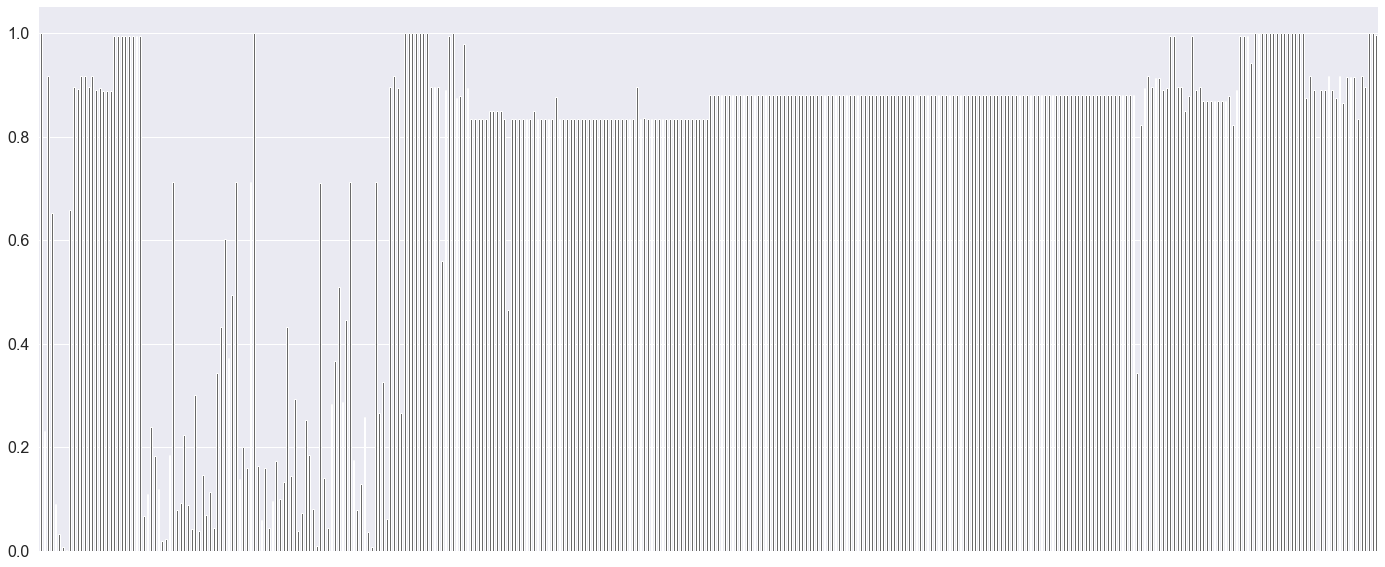

In [6]:
ax = msno.bar(azdias)

As we can see from the figure above there are a lot of columns with very few values now. Next we will have a look at missing values per column

#### Assess Missing Data in Each Column

Investigate patterns in the amount of missing data in each column.

In [7]:
column_nans = nans_count(azdias)
column_nans.sort_values('nan_count', ascending=False)

,nan_count
ALTER_KIND4,99.864792
TITEL_KZ,99.757636
ALTER_KIND3,99.307691
D19_VERSI_ONLINE_DATUM,99.170239
D19_TELKO_ONLINE_DATUM,99.079577
D19_BANKEN_LOKAL,98.151300
D19_BANKEN_OFFLINE_DATUM,97.791120
ALTER_KIND2,96.690047
D19_VERSI_OFFLINE_DATUM,96.296205
D19_TELKO_ANZ_12,96.271295


The table above shows the percent of missing values by colum

There are a few columns that are outliers in terms of the proportion of values that are missing.

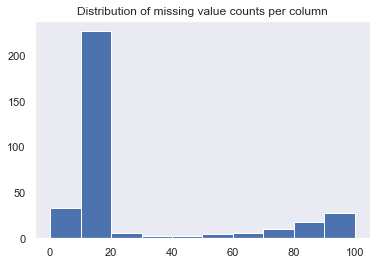

In [8]:
column_nans.hist(grid=False)
plt.title('Distribution of missing value counts per column')
plt.show()

We will remove all columns that have more than `column_nan_threshold` percentage missing values

In [9]:
column_nan_threshold = 75

nans_to_drop = column_nans[column_nans['nan_count'] > column_nan_threshold].index.tolist()
azdias.drop(nans_to_drop, axis=1, inplace=True)

# droped columns
nans_to_drop

['AGER_TYP',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_LOTTO',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_RATGEBER',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SCHUHE',
 'D19_SOZIALES',
 'D19_TELKO_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_TELKO_MOBILE',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_TELKO_ONLINE_DATUM',
 'D19_TELKO_REST',
 'D19_TIERARTIKEL',
 'D19_VERSAND_REST',
 'D19_VERSI_ANZ_12',
 'D19_VERSI_ANZ_24',
 'D19_VERSI_OFFLINE_DATUM',
 'D19_VERSI_ONLINE_DATUM',
 'D19_WEIN_FEINKOST',
 'TITEL_KZ']

In [10]:
drop_features = drop_features + nans_to_drop

#### Assess Missing Data in Each Row

Now, we'll perform a similar assessment for the rows of the dataset to asses how much data is missing in each row As with the columns, we should see some groups of points that have a very different numbers of missing values. We divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups.

In [11]:
row_nans = nans_count(azdias, axis=1)
row_nans.sort_values(by='nan_count', ascending=False)

,nan_count
390479,86.349206
770147,86.349206
579592,86.349206
579594,86.349206
579595,86.349206
770186,86.349206
261814,86.349206
579605,86.349206
770174,86.349206
579607,86.349206


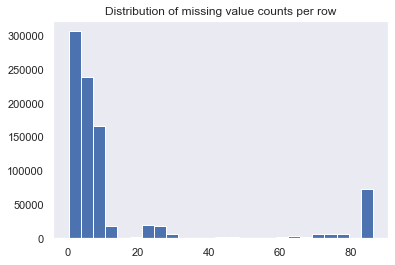

In [12]:
row_nans.hist(grid=False, bins=25)
plt.title('Distribution of missing value counts per row')
plt.show()

Divide the data into two subsets based on the number of missing values in each row.

In [13]:
row_nan_threshold = 85
nans_bellow_treshold = row_nans[row_nans['nan_count']<=row_nan_threshold]
nans_over_treshold = row_nans[row_nans['nan_count']>row_nan_threshold]

data_bellow_treshold = azdias.iloc[nans_bellow_treshold.index,:]
data_over_treshold = azdias.iloc[nans_over_treshold.index,:]

In [14]:
data_over_treshold.shape

(46168, 315)

Next we compare the distribution of values for the columns where there are no or few missing values, between the two subsets.

In [15]:
low_nan_threshold = 1
data_bellow_treshold_counts = nans_count(data_bellow_treshold)
bellow_treshold_columns = set(data_bellow_treshold_counts[data_bellow_treshold_counts['nan_count'] <= low_nan_threshold].index.tolist())

data_over_treshold_counts = nans_count(data_over_treshold)
over_treshold_columns = set(data_over_treshold_counts[data_over_treshold_counts['nan_count'] <= low_nan_threshold].index.tolist())

columns_with_low_nans = bellow_treshold_columns.intersection(over_treshold_columns)
columns_with_low_nans

{'CJT_GESAMTTYP',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'GFK_URLAUBERTYP',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'ONLINE_AFFINITAET',
 'RETOURTYP_BK_S',
 'RT_KEIN_ANREIZ',
 'RT_SCHNAEPPCHEN'}

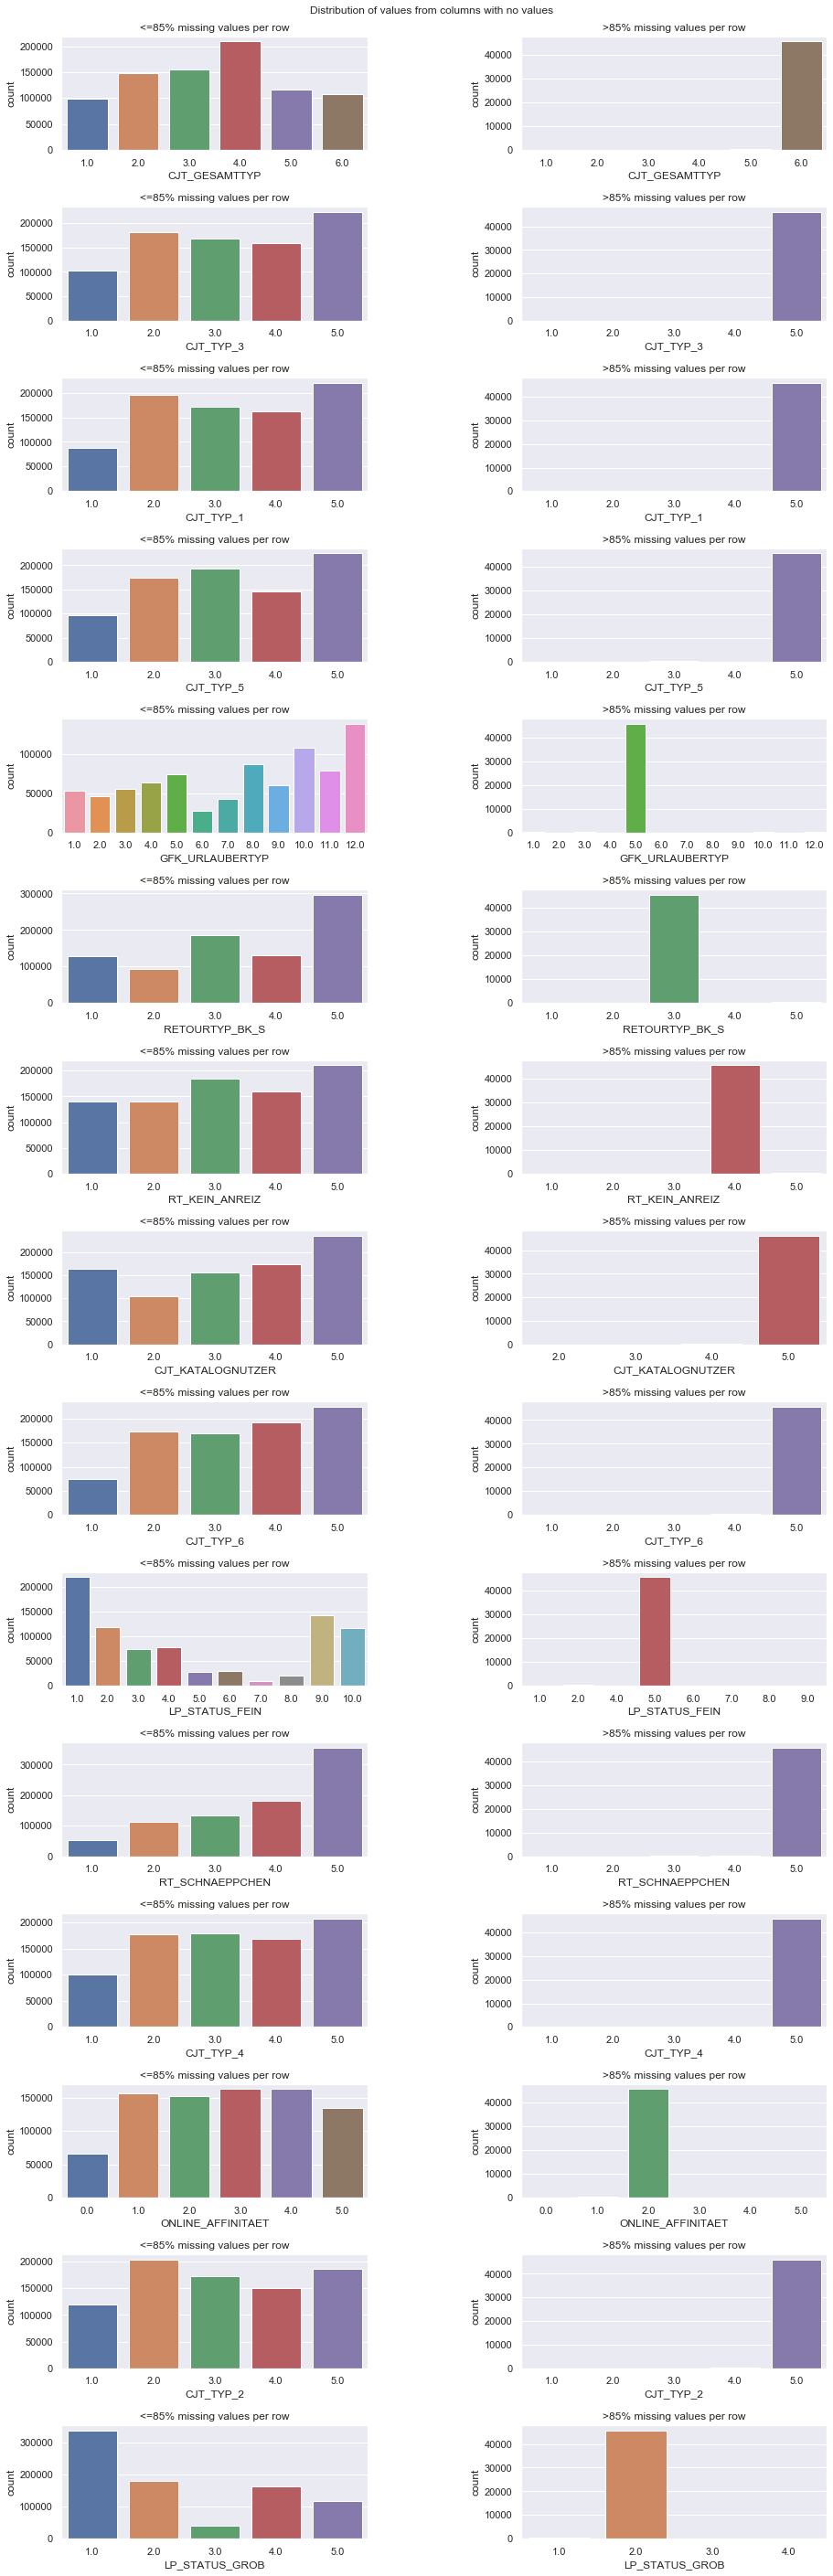

In [16]:
fig = compare_distributions(data_bellow_treshold, data_over_treshold, columns_with_low_nans, row_nan_threshold)

If the distributions of non-missing features looked similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. In this case, however none of the distributions look similar so we will keep all the rows.

### Select and Re-encode Features

How many features are there of each data type?

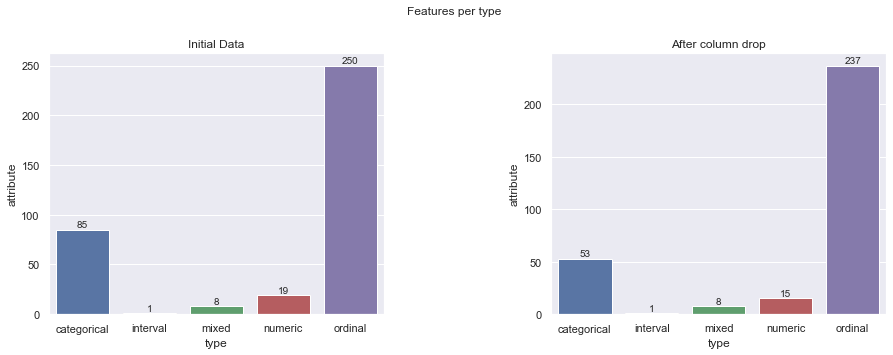

In [17]:
initial_data = feat_info.groupby('type').agg('count')

feat_info_afer_drop = feat_info[feat_info['attribute'].isin(azdias.columns.values)]
after_column_drop = feat_info_afer_drop.groupby('type').agg('count')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), gridspec_kw={'wspace':0.5})
fig.subplots_adjust(top=0.85)
fig.suptitle('Features per type')
    
ax1 = sns.barplot(x=initial_data.index, y=initial_data['attribute'], ax=axes[0])
ax1.set(title='Initial Data')
ax2 = sns.barplot(x=after_column_drop.index, y=after_column_drop['attribute'], ax=axes[1])
ax2.set(title='After column drop')

def autolabel(ax):
    for cat in ax.patches:
        height = cat.get_height()
        ax.text(cat.get_x() + cat.get_width()/2., height, '%d' % int(height), ha='center', va='bottom')

autolabel(ax1)
autolabel(ax2)
        
plt.show()

#### Categorical Features

For categorical data, we need to encode the levels as dummy variables. Depending on the number of categories, we can perform one of the following:

* For binary (two-level) categoricals that take numeric values, we can keep them without needing to do anything.
* If there are binary variables that takes on non-numeric values we need to re-encode the values as numbers or create a dummy variable.
* For multi-level categoricals (three or more values), we can choose to encode the values using multiple dummy variables (e.g. via OneHotEncoder)

In [18]:
categorical_features = feat_info_afer_drop[feat_info_afer_drop['type'] == 'categorical']['attribute'].tolist()
print(categorical_features)
print('\n')
unique_values(azdias[categorical_features])

['ANREDE_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CJT_GESAMTTYP', 'D19_BUCH_CD', 'D19_KONSUMTYP', 'KK_KUNDENTYP', 'D19_SONSTIGE', 'D19_TECHNIK', 'D19_VERSICHERUNGEN', 'D19_VOLLSORTIMENT', 'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'KBA05_MODTEMP', 'KBA05_SEG6', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'OST_WEST_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_KONSUMTYP_MAX', 'DSL_FLAG', 'FIRMENDICHTE', 'HH_DELTA_FLAG', 'KOMBIALTER', 'KONSUMZELLE', 'MOBI_RASTER', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE', 'SOHO_KZ', 'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VHA', 'VHN', 'GEMEINDETYP']




ANREDE_KZ: [1, 2]
CAMEO_DEUG_2015: [nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0]
CAMEO_DEU_2015: [nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C', '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D', '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F', '1C']
CJT_GESAMTTYP: [2.0, 5.0, 3.0, 4.0, 1.0, 6.0, nan]
D19_BUCH_CD: [nan, 6.0, 5.0, 3.0, 1.0, 7.0, 4.0, 2.0]
D19_KONSUMTYP: [nan, 9.0, 1.0, 4.0, 3.0, 6.0, 5.0, 2.0]
KK_KUNDENTYP: [nan, 1.0, 3.0, 6.0, 4.0, 2.0, 5.0]
D19_SONSTIGE: [nan, 6.0, 4.0, 7.0, 5.0, 3.0, 2.0, 1.0]
D19_TECHNIK: [nan, 6.0, 5.0, 7.0, 3.0, 1.0, 4.0, 2.0]
D19_VERSICHERUNGEN: [nan, 3.0, 6.0, 4.0, 5.0, 7.0, 2.0, 1.0]
D19_VOLLSORTIMENT: [nan, 7.0, 6.0, 3.0, 2.0, 5.0, 4.0, 1.0]
FINANZTYP: [4, 1, 6, 5, 2, 3]
GEBAEUDETYP: [nan, 8.0, 1.0, 3.0, 2.0, 6.0, 4.0, 5.0]
GFK_URLAUBERTYP: [10.0, 1.0, 5.0, 12.0, 9.0, 3.0, 8.0, 11.0, 4.0, 2.0, 7.0, 6.0, nan]
GREEN_AVANTGARDE:

We can observe that:

* Almost all features have missing values that we have to deal with
* Features like `CAMEO_DEU_2015` and `OST_WEST_KZ` contain strings that we need to encode as numbers

Change ```OST_WEST_KZ``` to have numeric values

In [19]:
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].map({'W': 1, 'O': 2})
azdias['OST_WEST_KZ'].head()

0    NaN
1    1.0
2    1.0
3    1.0
4    1.0
Name: OST_WEST_KZ, dtype: float64

Fill missing values with the most frequent value

In [20]:
azdias[categorical_features] = azdias[categorical_features].fillna(azdias[categorical_features].mode().iloc[0])
unique_values(azdias[categorical_features])

ANREDE_KZ: [1, 2]
CAMEO_DEUG_2015: [8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0]
CAMEO_DEU_2015: ['6B', '8A', '4C', '2A', '8C', '4A', '2D', '1A', '1E', '9D', '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C', '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D', '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F', '1C']
CJT_GESAMTTYP: [2.0, 5.0, 3.0, 4.0, 1.0, 6.0]
D19_BUCH_CD: [6.0, 5.0, 3.0, 1.0, 7.0, 4.0, 2.0]
D19_KONSUMTYP: [9.0, 1.0, 4.0, 3.0, 6.0, 5.0, 2.0]
KK_KUNDENTYP: [3.0, 1.0, 6.0, 4.0, 2.0, 5.0]
D19_SONSTIGE: [6.0, 4.0, 7.0, 5.0, 3.0, 2.0, 1.0]
D19_TECHNIK: [6.0, 5.0, 7.0, 3.0, 1.0, 4.0, 2.0]
D19_VERSICHERUNGEN: [6.0, 3.0, 4.0, 5.0, 7.0, 2.0, 1.0]
D19_VOLLSORTIMENT: [6.0, 7.0, 3.0, 2.0, 5.0, 4.0, 1.0]
FINANZTYP: [4, 1, 6, 5, 2, 3]
GEBAEUDETYP: [1.0, 8.0, 3.0, 2.0, 6.0, 4.0, 5.0]
GFK_URLAUBERTYP: [10.0, 1.0, 5.0, 12.0, 9.0, 3.0, 8.0, 11.0, 4.0, 2.0, 7.0, 6.0]
GREEN_AVANTGARDE: [0, 1]
KBA05_MODTEMP: [3.0, 1.0, 4.0, 5.0, 2.0, 6.0]
KBA05_

In [21]:
cat_numeric = list(set(categorical_features)-set(['CAMEO_DEU_2015']))
azdias[cat_numeric] = azdias[cat_numeric].astype('int8')
azdias[categorical_features] = azdias[categorical_features].astype('category')

#### Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention:

* "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, we should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
* "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. We break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

In [22]:
feat_info = feat_info[feat_info['attribute'].isin(azdias.columns.values)]
mixed_type_features = feat_info[feat_info['type'] == 'mixed']['attribute']
mixed_type_features 

11           CAMEO_INTL_2015
100             KBA05_BAUMAX
266      LP_LEBENSPHASE_FEIN
267      LP_LEBENSPHASE_GROB
280              PLZ8_BAUMAX
283    PRAEGENDE_JUGENDJAHRE
305                 WOHNLAGE
361             KBA13_BAUMAX
Name: attribute, dtype: object

Fill the missing values with the most frequent value

In [23]:
azdias[mixed_type_features] = azdias[mixed_type_features].fillna(azdias[mixed_type_features].mode().iloc[0])

Investigate `PRAEGENDE_JUGENDJAHRE` and engineer two new variables.

In [24]:
unique_values(azdias[['PRAEGENDE_JUGENDJAHRE']])

PRAEGENDE_JUGENDJAHRE: [14.0, 15.0, 8.0, 3.0, 10.0, 11.0, 5.0, 9.0, 6.0, 4.0, 2.0, 1.0, 12.0, 13.0, 7.0]



Re-engineer PRAEGENDE_JUGENDJAHRE

In [25]:
decade = {'1.0': 1, '2.0': 1, '3.0': 2, '4.0': 2, '5.0': 3, '6.0': 3, '7.0': 3, '8.0': 4, '9.0': 4, '10.0': 5, 
          '11.0': 5, '12.0': 5, '13.0': 5, '14.0': 6, '15.0': 6}

movement = {'1.0': 1, '2.0': 2, '3.0': 1, '4.0': 2, '5.0': 1, '6.0': 2, '7.0': 2, '8.0': 1, '9.0': 2, '10.0': 1, 
            '11.0': 2, '12.0': 1, '13.0': 2, '14.0': 1, '15.0': 2}

azdias['PRAEGENDE_JUGENDJAHRE'] = azdias['PRAEGENDE_JUGENDJAHRE'].astype('str')
azdias['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].replace(decade)
azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'].replace(movement)
azdias = azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

In [26]:
decade_movement = ['PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT']
azdias[decade_movement] = azdias[decade_movement].astype('category')

Investigate "CAMEO_INTL_2015" and engineer two new variables.

In [27]:
unique_values(azdias[['CAMEO_INTL_2015']])

CAMEO_INTL_2015: [51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0, 41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0]



Re-engineer CAMEO_INTL_2015

In [28]:
azdias['CAMEO_INTL_2015_WEALTH'] = azdias['CAMEO_INTL_2015'].apply(lambda x: list(str(x))[0])
azdias['CAMEO_INTL_2015_LIFE_STAGE'] = azdias['CAMEO_INTL_2015'].apply(lambda x: list(str(x))[1])
azdias = azdias.drop('CAMEO_INTL_2015', axis=1)

In [29]:
wealth_life = ['CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_LIFE_STAGE']
azdias[wealth_life] = azdias[wealth_life].astype('category')

Let's look at all mixed-type features

In [30]:
feat_info = feat_info[feat_info['attribute'].isin(azdias.columns.values)]
remaining_mix_type = feat_info[feat_info['type'] == 'mixed']['attribute']
unique_values(azdias[remaining_mix_type])

KBA05_BAUMAX: [1.0, 5.0, 2.0, 3.0, 4.0]
LP_LEBENSPHASE_FEIN: [15.0, 21.0, 3.0, 1.0, 32.0, 8.0, 2.0, 5.0, 10.0, 4.0, 6.0, 23.0, 12.0, 20.0, 11.0, 25.0, 13.0, 7.0, 18.0, 31.0, 19.0, 38.0, 35.0, 30.0, 22.0, 14.0, 33.0, 29.0, 24.0, 28.0, 37.0, 26.0, 39.0, 27.0, 36.0, 9.0, 34.0, 40.0, 16.0, 17.0]
LP_LEBENSPHASE_GROB: [4.0, 6.0, 1.0, 2.0, 10.0, 3.0, 5.0, 7.0, 12.0, 11.0, 9.0, 8.0]
PLZ8_BAUMAX: [1.0, 2.0, 4.0, 5.0, 3.0]
WOHNLAGE: [3.0, 4.0, 2.0, 7.0, 5.0, 1.0, 8.0, 0.0]
KBA13_BAUMAX: [1.0, 2.0, 4.0, 5.0, 3.0]



In [31]:
azdias[remaining_mix_type] = azdias[remaining_mix_type].astype('int8').astype('category')

#### Ordinal features

In [32]:
ordinal_features = feat_info_afer_drop[feat_info_afer_drop['type'] == 'ordinal']['attribute'].tolist()
print(ordinal_features)
print('\n')
unique_values(azdias[ordinal_features])

['ALTERSKATEGORIE_GROB', 'BALLRAUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_TELKO_DATUM', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'EWDICHTE', 'FINANZ_ANLEGER', 'FINANZ_HAUSBAUER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'GEBAEUDETYP_RASTER', 'HEALTH_TYP', 'HH_EINKOMMEN_SCORE', 'INNENSTADT', 'KBA05_ALTER1', 'KBA05_ALTER2', 'KBA05_ALTER3', 'KBA05_ALTER4', 'KBA05_ANHANG', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_AUTOQUOT', 'KBA05_CCM1', 'KBA05_CCM2', 'KBA05_CCM3', 'KBA05_CCM4', 'KBA05_DIESEL', 'KBA05_FRAU', 'KBA05_GBZ', 'KBA05_HERST1', 'KBA05_HERST2', 'KBA05_HERST3', 'KBA05_HERST4', 'KBA05_HERST5', 'KBA05_HERSTTEMP', 'KBA05_KRSAQUOT', 'KBA05_KRSHERST1', 'KBA05_KRSHERST2

ALTERSKATEGORIE_GROB: [2.0, 1.0, 3.0, 4.0, nan]
BALLRAUM: [nan, 6.0, 2.0, 4.0, 3.0, 7.0, 1.0, 5.0]
D19_BANKEN_ONLINE_QUOTE_12: [nan, 0.0, 10.0, 8.0, 5.0, 9.0, 7.0, 6.0, 3.0, 4.0, 2.0, 1.0]
D19_GESAMT_ANZ_12: [nan, 6.0, 1.0, 2.0, 3.0, 4.0, 5.0]
D19_GESAMT_ANZ_24: [nan, 6.0, 1.0, 2.0, 3.0, 5.0, 4.0]
D19_GESAMT_DATUM: [nan, 1.0, 3.0, 5.0, 9.0, 4.0, 7.0, 6.0, 8.0, 2.0]
D19_GESAMT_OFFLINE_DATUM: [nan, 6.0, 8.0, 9.0, 5.0, 2.0, 4.0, 1.0, 7.0, 3.0]
D19_GESAMT_ONLINE_DATUM: [nan, 1.0, 3.0, 5.0, 9.0, 4.0, 7.0, 6.0, 8.0, 2.0]
D19_GESAMT_ONLINE_QUOTE_12: [nan, 0.0, 10.0, 7.0, 9.0, 5.0, 8.0, 6.0, 3.0, 4.0, 2.0, 1.0]
D19_TELKO_DATUM: [nan, 6.0, 9.0, 8.0, 7.0, 5.0, 4.0, 2.0, 1.0, 3.0]
D19_VERSAND_ANZ_12: [nan, 6.0, 1.0, 2.0, 5.0, 3.0, 4.0]
D19_VERSAND_ANZ_24: [nan, 6.0, 2.0, 1.0, 3.0, 4.0, 5.0]
D19_VERSAND_DATUM: [nan, 1.0, 5.0, 9.0, 4.0, 8.0, 7.0, 6.0, 3.0, 2.0]
D19_VERSAND_OFFLINE_DATUM: [nan, 9.0, 6.0, 8.0, 5.0, 2.0, 1.0, 4.0, 7.0, 3.0]
D19_VERSAND_ONLINE_DATUM: [nan, 1.0, 5.0, 9.0, 4.0, 8.0, 7.0,

KBA13_SEG_GELAENDEWAGEN: [nan, 2.0, 5.0, 3.0, 4.0, 1.0]
KBA13_SEG_GROSSRAUMVANS: [nan, 3.0, 4.0, 1.0, 5.0, 2.0]
KBA13_SEG_KLEINST: [nan, 2.0, 3.0, 5.0, 4.0, 1.0]
KBA13_SEG_KLEINWAGEN: [nan, 2.0, 3.0, 4.0, 1.0, 5.0]
KBA13_SEG_KOMPAKTKLASSE: [nan, 5.0, 1.0, 4.0, 3.0, 2.0]
KBA13_SEG_MINIVANS: [nan, 4.0, 3.0, 2.0, 1.0, 5.0]
KBA13_SEG_MINIWAGEN: [nan, 2.0, 3.0, 5.0, 4.0, 1.0]
KBA13_SEG_MITTELKLASSE: [nan, 3.0, 2.0, 4.0, 5.0, 1.0]
KBA13_SEG_OBEREMITTELKLASSE: [nan, 3.0, 4.0, 5.0, 2.0, 1.0]
KBA13_SEG_OBERKLASSE: [nan, 3.0, 1.0, 4.0, 5.0, 0.0, 2.0]
KBA13_SEG_SONSTIGE: [nan, 2.0, 5.0, 3.0, 4.0, 1.0]
KBA13_SEG_SPORTWAGEN: [nan, 3.0, 4.0, 5.0, 1.0, 2.0, 0.0]
KBA13_SEG_UTILITIES: [nan, 3.0, 5.0, 2.0, 4.0, 1.0]
KBA13_SEG_VAN: [nan, 4.0, 3.0, 2.0, 1.0, 5.0]
KBA13_SEG_WOHNMOBILE: [nan, 2.0, 5.0, 3.0, 4.0, 0.0, 1.0]
KBA13_SITZE_4: [nan, 3.0, 4.0, 5.0, 2.0, 1.0]
KBA13_SITZE_5: [nan, 3.0, 2.0, 1.0, 4.0, 5.0]
KBA13_SITZE_6: [nan, 4.0, 3.0, 2.0, 5.0, 1.0]
KBA13_TOYOTA: [nan, 2.0, 3.0, 4.0, 5.0, 1.0]
KBA13

Fill the missing values with the most frequent value

In [33]:
azdias[ordinal_features] = azdias[ordinal_features].fillna(azdias[ordinal_features].mode().iloc[0])
azdias[ordinal_features] = azdias[ordinal_features].astype('int8').astype('category')

#### Interval features

In [34]:
interval_features = feat_info[feat_info['type'] == 'interval']['attribute'].tolist()
print(interval_features)
print('\n')
unique_values(azdias[interval_features])

['ALTER_HH']




ALTER_HH: [nan, 17.0, 13.0, 20.0, 10.0, 14.0, 16.0, 21.0, 11.0, 19.0, 15.0, 9.0, 18.0, 8.0, 7.0, 12.0, 4.0, 3.0, 6.0, 5.0, 2.0, 1.0]



Fill the missing values with the most frequent value

In [35]:
azdias[interval_features] = azdias[interval_features].fillna(azdias[interval_features].mode().iloc[0])
azdias[interval_features] = azdias[interval_features].astype('int8').astype('category')

#### Numerical features

In [36]:
numeric_features = feat_info[feat_info['type'] == 'numeric']['attribute'].tolist()
print(numeric_features)
print('\n')
unique_values(azdias[numeric_features])

['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR', 'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE', 'EINGEZOGENAM_HH_JAHR', 'EXTSEL992', 'VERDICHTUNGSRAUM', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11']




ANZ_HAUSHALTE_AKTIV: [nan, 11.0, 10.0, 1.0, 3.0, 5.0, 4.0, 6.0, 2.0, 9.0, 0.0, 14.0, 13.0, 8.0, 7.0, 44.0, 25.0, 36.0, 16.0, 272.0, 33.0, 15.0, 12.0, 22.0, 21.0, 20.0, 67.0, 23.0, 18.0, 27.0, 24.0, 31.0, 39.0, 19.0, 30.0, 17.0, 29.0, 61.0, 54.0, 88.0, 49.0, 60.0, 38.0, 34.0, 48.0, 35.0, 62.0, 26.0, 45.0, 42.0, 28.0, 77.0, 47.0, 50.0, 236.0, 137.0, 43.0, 52.0, 41.0, 76.0, 63.0, 32.0, 40.0, 37.0, 59.0, 53.0, 57.0, 118.0, 66.0, 95.0, 78.0, 70.0, 46.0, 185.0, 73.0, 154.0, 80.0, 102.0, 92.0, 126.0, 94.0, 71.0, 68.0, 81.0, 69.0, 121.0, 258.0, 58.0, 86.0, 124.0, 85.0, 90.0, 128.0, 51.0, 72.0, 64.0, 56.0, 83.0, 150.0, 259.0, 91.0, 160.0, 134.0, 169.0, 246.0, 82.0, 114.0, 183.0, 116.0, 74.0, 143.0, 99.0, 216.0, 98.0, 125.0, 112.0, 123.0, 55.0, 120.0, 75.0, 141.0, 103.0, 87.0, 89.0, 223.0, 93.0, 179.0, 135.0, 149.0, 97.0, 101.0, 110.0, 79.0, 111.0, 109.0, 65.0, 84.0, 367.0, 162.0, 195.0, 107.0, 119.0, 331.0, 122.0, 161.0, 157.0, 175.0, 177.0, 136.0, 104.0, 316.0, 127.0, 100.0, 180.0, 155.0, 133.

KBA13_ANZAHL_PKW: [nan, 963.0, 712.0, 596.0, 435.0, 1300.0, 867.0, 758.0, 511.0, 530.0, 424.0, 1106.0, 486.0, 876.0, 387.0, 621.0, 694.0, 537.0, 1500.0, 711.0, 545.0, 348.0, 452.0, 439.0, 442.0, 469.0, 670.0, 203.0, 635.0, 309.0, 463.0, 352.0, 524.0, 891.0, 444.0, 652.0, 378.0, 810.0, 594.0, 395.0, 713.0, 584.0, 354.0, 633.0, 961.0, 363.0, 886.0, 385.0, 874.0, 990.0, 666.0, 380.0, 218.0, 847.0, 693.0, 429.0, 423.0, 392.0, 1800.0, 504.0, 632.0, 581.0, 638.0, 1400.0, 1023.0, 546.0, 1114.0, 554.0, 799.0, 738.0, 622.0, 228.0, 578.0, 612.0, 329.0, 229.0, 768.0, 834.0, 556.0, 668.0, 436.0, 565.0, 209.0, 534.0, 994.0, 474.0, 437.0, 958.0, 477.0, 421.0, 127.0, 453.0, 656.0, 681.0, 409.0, 367.0, 311.0, 293.0, 613.0, 526.0, 460.0, 665.0, 520.0, 492.0, 748.0, 625.0, 340.0, 242.0, 611.0, 708.0, 602.0, 1008.0, 716.0, 873.0, 598.0, 1600.0, 763.0, 324.0, 304.0, 896.0, 683.0, 419.0, 797.0, 605.0, 399.0, 615.0, 710.0, 521.0, 563.0, 369.0, 871.0, 657.0, 599.0, 717.0, 595.0, 153.0, 884.0, 1205.0, 473.0, 

MIN_GEBAEUDEJAHR: [nan, 1992.0, 1997.0, 2005.0, 2009.0, 1994.0, 1996.0, 2002.0, 2015.0, 1991.0, 1993.0, 1995.0, 2003.0, 2014.0, 2008.0, 2006.0, 2000.0, 1990.0, 2004.0, 1999.0, 1998.0, 2001.0, 2007.0, 2013.0, 1989.0, 2011.0, 2012.0, 2010.0, 1987.0, 1988.0, 1985.0, 2016.0, 1986.0]
ANZ_KINDER: [nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 9.0, 7.0, 11.0, 8.0]
ANZ_STATISTISCHE_HAUSHALTE: [nan, 12.0, 7.0, 2.0, 3.0, 5.0, 6.0, 1.0, 14.0, 4.0, 11.0, 13.0, 30.0, 22.0, 36.0, 244.0, 10.0, 32.0, 8.0, 9.0, 18.0, 17.0, 16.0, 67.0, 19.0, 15.0, 26.0, 20.0, 23.0, 33.0, 34.0, 68.0, 53.0, 21.0, 42.0, 57.0, 28.0, 25.0, 60.0, 35.0, 29.0, 43.0, 64.0, 27.0, 46.0, 24.0, 48.0, 31.0, 56.0, 37.0, 243.0, 157.0, 39.0, 40.0, 71.0, 63.0, 38.0, 44.0, 50.0, 101.0, 66.0, 41.0, 81.0, 47.0, 192.0, 131.0, 149.0, 74.0, 84.0, 80.0, 137.0, 45.0, 94.0, 65.0, 54.0, 87.0, 69.0, 125.0, 61.0, 82.0, 73.0, 72.0, 86.0, 292.0, 70.0, 83.0, 91.0, 112.0, 58.0, 51.0, 75.0, 52.0, 90.0, 140.0, 49.0, 212.0, 79.0, 152.0, 142.0, 166.0, 251.0, 99.0

Fill the missing values with the median

In [37]:
azdias[numeric_features] = azdias[numeric_features].fillna(azdias[numeric_features].median())
azdias[numeric_features] = azdias[numeric_features].astype('int32')

### Exploratory Visualization

Number of features per information level

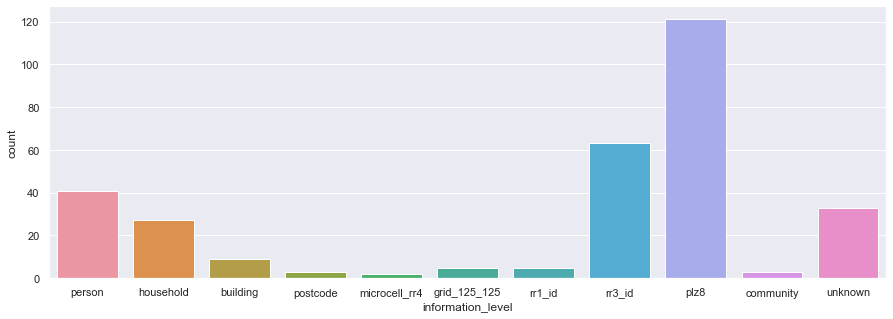

In [164]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x='information_level', data=feat_info, ax=ax)

In [165]:
def heatmap(x, y, size):
    fig, ax = plt.subplots(figsize=(20,20))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
    return fig

In [168]:
azdias_numeric = azdias.drop(['LNR', 'CAMEO_DEU_2015'], axis=1).astype('int32')

#### Person related features correlation

In [147]:
person_level_columns = feat_info[feat_info['information_level']=='person']['attribute'].tolist()

In [160]:
corr = azdias_numeric[person_level_columns].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']

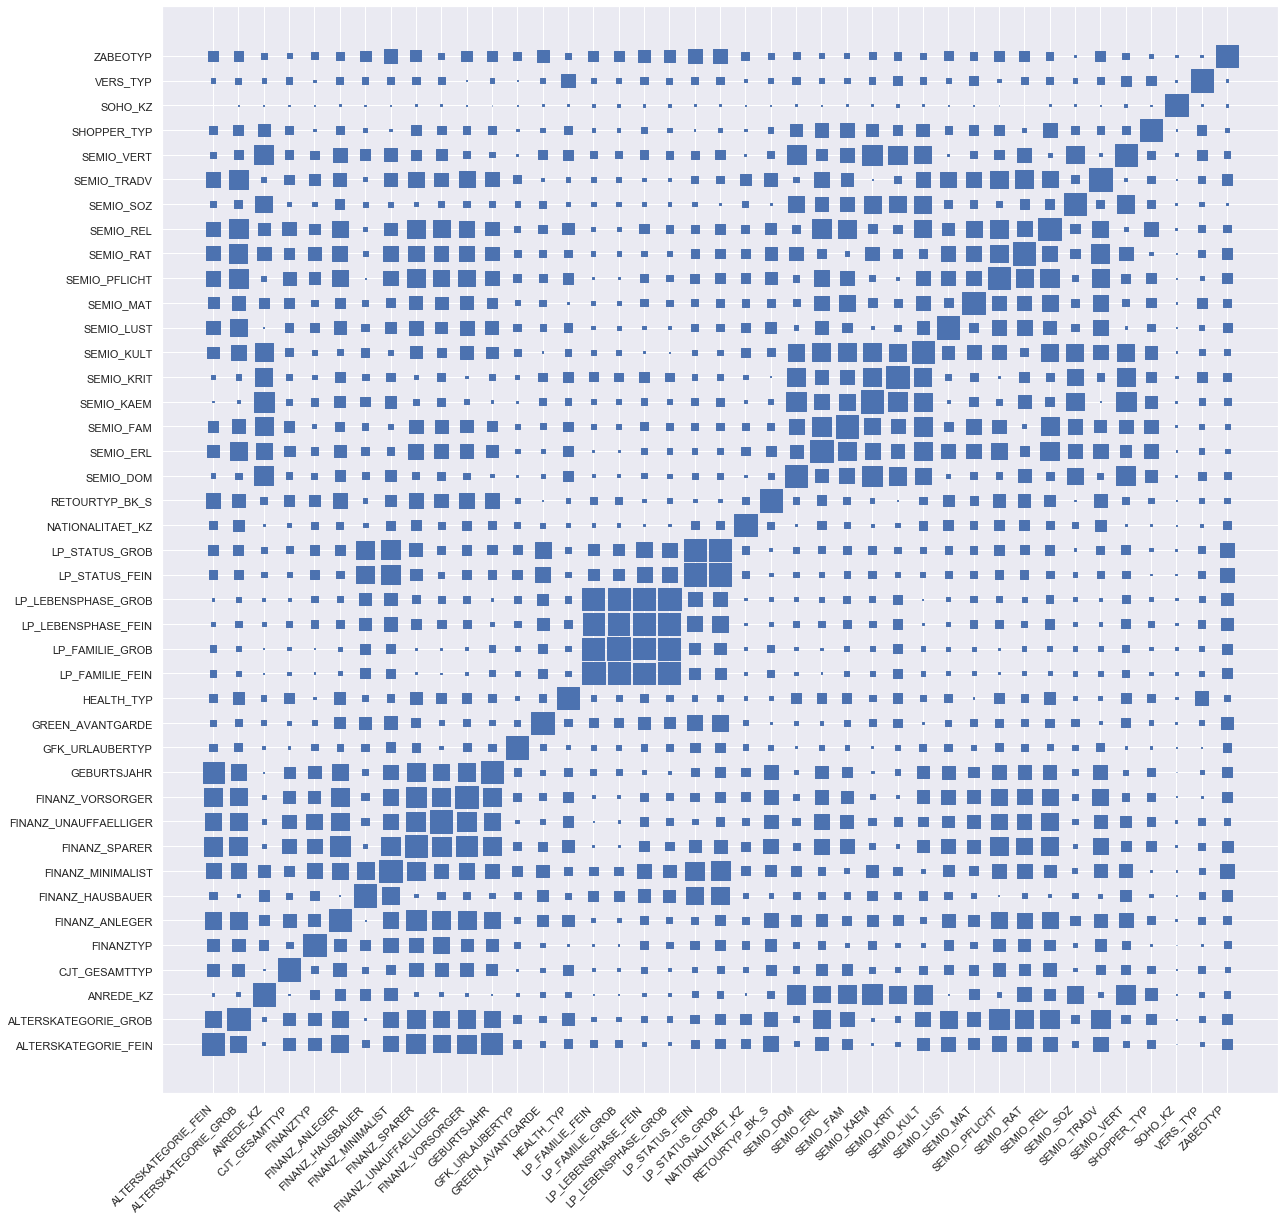

In [166]:
fig = heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)
fig.savefig('person_level_correlation.png', dpi=fig.dpi)

#### Household related features correlation

In [167]:
household_level_columns = feat_info[feat_info['information_level']=='household']['attribute'].tolist()

In [169]:
corr = azdias_numeric[household_level_columns].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']

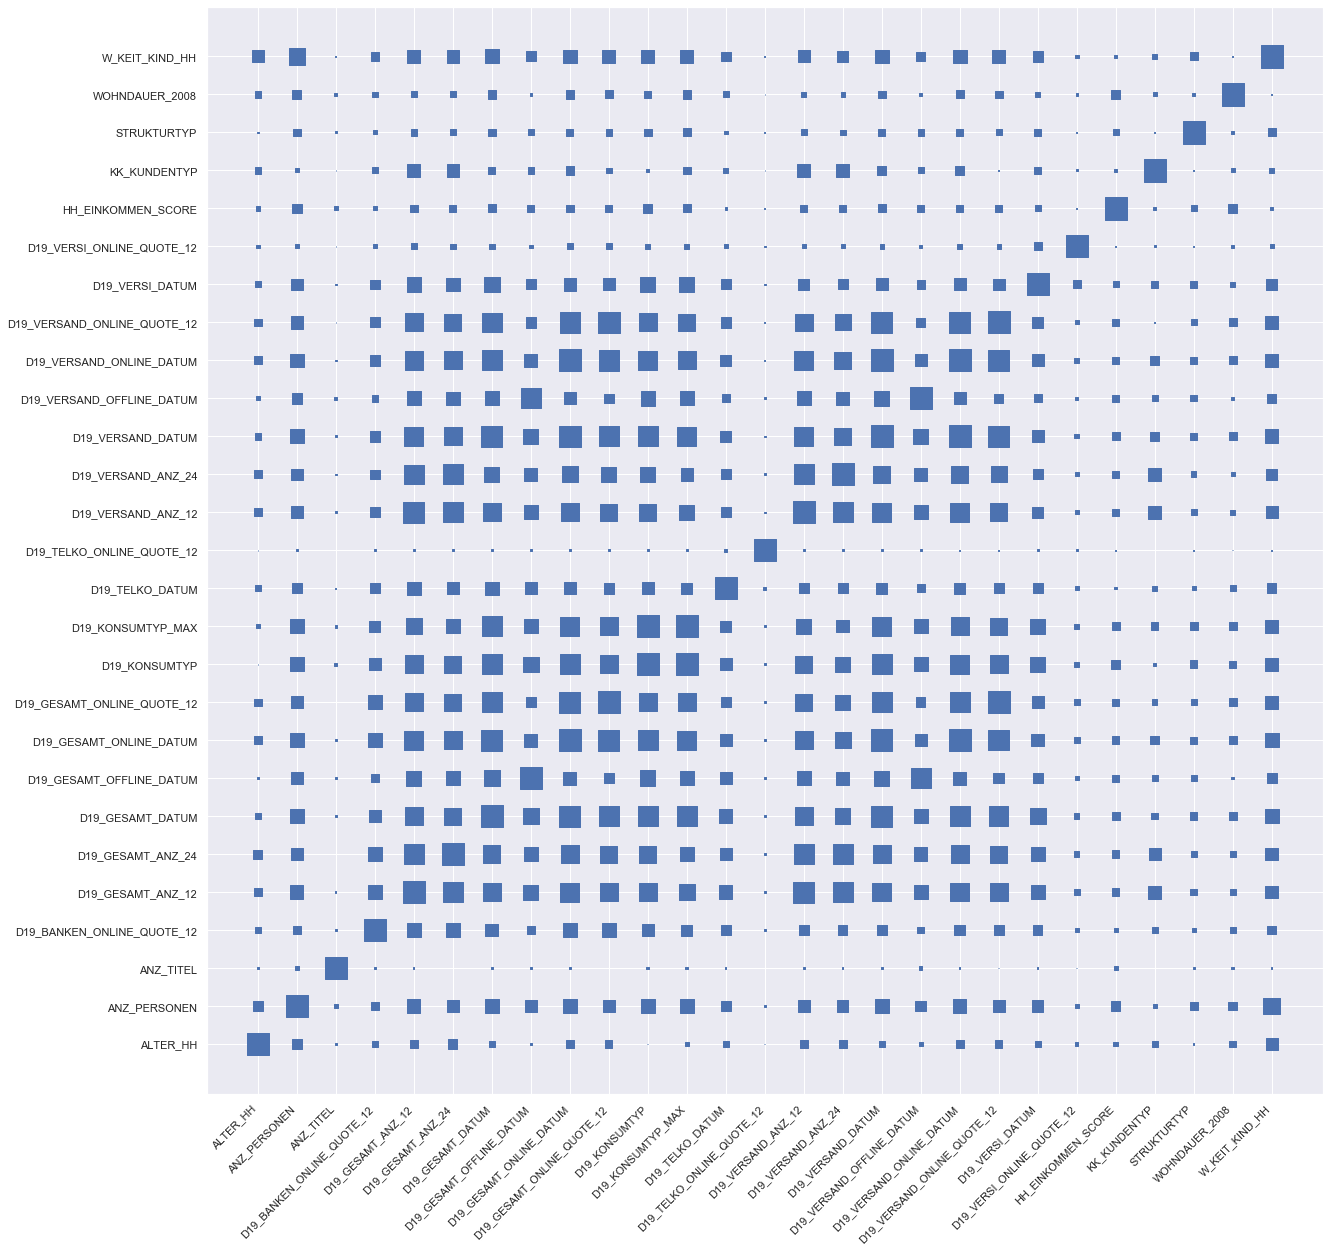

In [170]:
fig = heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)
fig.savefig('household_level_correlation.png', dpi=fig.dpi)

#### Building related features correlation

In [171]:
building_level_columns = feat_info[feat_info['information_level']=='building']['attribute'].tolist()

In [172]:
corr = azdias_numeric[building_level_columns].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']

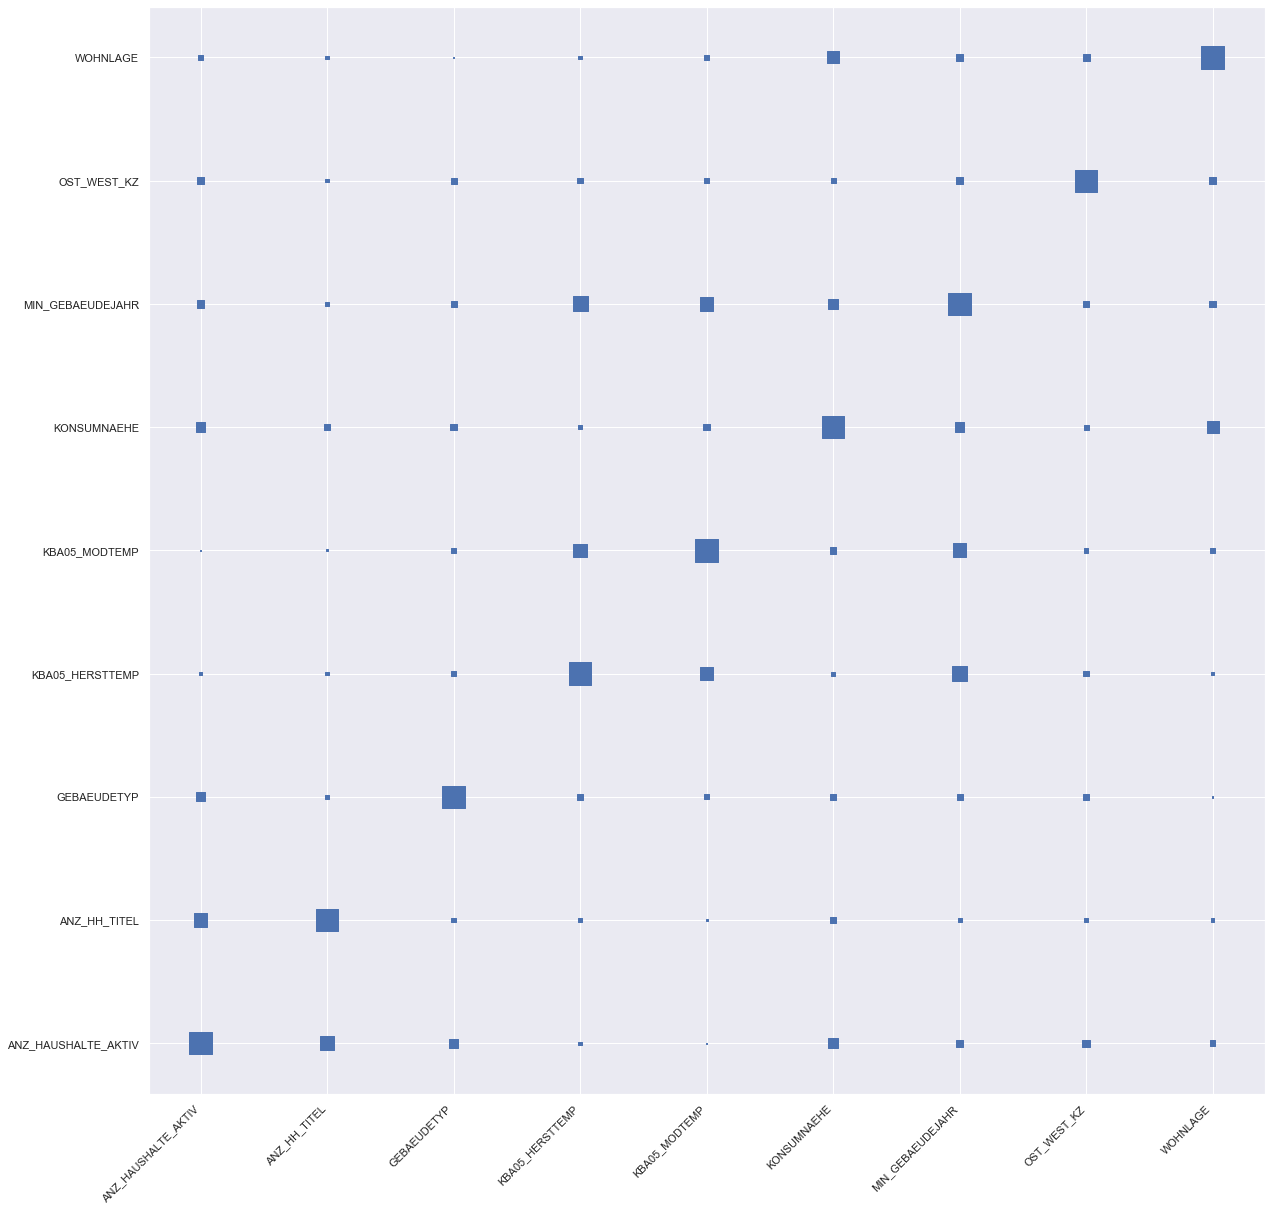

In [173]:
fig = heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)
fig.savefig('building_level_columns_level_correlation.png', dpi=fig.dpi)

## Preprocessing Pipeline

Now we put all the preprocessing steps inside a pipeline so we can apply it in one go

### Parse Pipeline

In [4]:
parse_pipeline = Pipeline( steps = [('parse_missing', MissingOrUnknownParser(feat_info)),
                                    ('drop_features', FeatureSelector(features_to_drop, exclude=True))])

### Categorical Pipeline

In [5]:
categorical_pipeline = Pipeline( steps = [( 'cat_transformer', CategoricalTransformer()), 
                                          ( 'one_hot_encoder', OneHotEncoder(categories='auto', sparse = False, handle_unknown='ignore' ))])

### Ordinal Pipeline

In [6]:
ordinal_pipeline = Pipeline( steps = [('imputer', SimpleImputer(missing_values=np.nan, strategy = 'most_frequent'))])

### Numerical Pipeline

In [7]:
numerical_pipeline = Pipeline( steps = [('imputer', SimpleImputer(missing_values=np.nan, strategy = 'median')), 
                                        ('std_scaler', StandardScaler())])

### Passthrough Pipeline

In [8]:
passthrough_pipeline = Pipeline( steps = [( 'passthrough_transformer', PassthroughTransformer())])

### Transform Pipeline

In [9]:
transform_pipeline = ColumnTransformer(transformers=[('categorical_pipeline', categorical_pipeline, categorical_features),
                                                     ('ordinal_pipeline', ordinal_pipeline, ordinal_features),
                                                     ('numerical_pipeline', numerical_pipeline, numeric_features),
                                                     ('passthrough_pipeline', passthrough_pipeline, passthrough_features)
                                                    ])

### Clean Pipeline

In [10]:
clean_pipeline = Pipeline(steps = [('parse_pipeline', parse_pipeline), 
                                   ('transform_pipeline', transform_pipeline)])

### Running the Pipeline

Apply feature scaling to the general population demographics data

In [11]:
azdias = clean_pipeline.fit_transform(azdias)

Put the features back

In [12]:
transformed_pipeline = clean_pipeline.named_steps['transform_pipeline'].transformers_[0][1]

final_categorical_features = transformed_pipeline.named_steps['cat_transformer'].get_feature_names()
one_hot_encoded_features = clean_pipeline.named_steps['transform_pipeline'].transformers_[0][1].named_steps['one_hot_encoder'].get_feature_names(final_categorical_features).tolist()

all_features = one_hot_encoded_features + ordinal_features + numeric_features + passthrough_features

azdias = pd.DataFrame(azdias, columns=all_features)
azdias.head()

,ANREDE_KZ_1,ANREDE_KZ_2,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,...,MIN_GEBAEUDEJAHR,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,EINGEZOGENAM_HH_JAHR,EXTSEL992,VERDICHTUNGSRAUM,VK_DHT4A,VK_DISTANZ,VK_ZG11,LNR
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.359845,-0.292527,-0.302057,-0.098898,0.023455,-0.395656,-0.000407,0.137664,0.018645,910215.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.359845,-0.292527,0.357993,0.048946,0.023455,-0.519516,0.731728,1.102566,1.527603,910220.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.359845,-0.292527,-0.008701,-0.542432,-2.641994,-0.395656,1.097796,0.459298,0.018645,910225.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.213535,-0.292527,-0.375395,-0.838120,-0.376363,-0.519516,0.365661,0.780932,1.904842,910226.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.359845,-0.292527,-0.302057,0.048946,0.023455,-0.395656,-1.098609,-0.827238,-0.735833,910241.0


In [13]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 686 entries, ANREDE_KZ_1 to LNR
dtypes: float64(686)
memory usage: 4.6 GB


In [14]:
azdias, _ = reduce_mem_usage(azdias)

Memory usage of dataframe:  4664.4410400390625  MB



___MEMORY USAGE AFTER COMPLETION:___
Memory usage is: 623.8520565032959 MB
This is 13.37% of the initial size


Save the processed data frame

In [17]:
import pyarrow
azdias.to_parquet('temp/azdias_processed.gzip', compression='gzip')

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)


Save the pipeline

In [20]:
dump(clean_pipeline, 'temp/preprocessing_pipeline.joblib') 

['temp/preprocessing_pipeline.joblib']